/TL/epigenetics2/work/pebert/conda/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


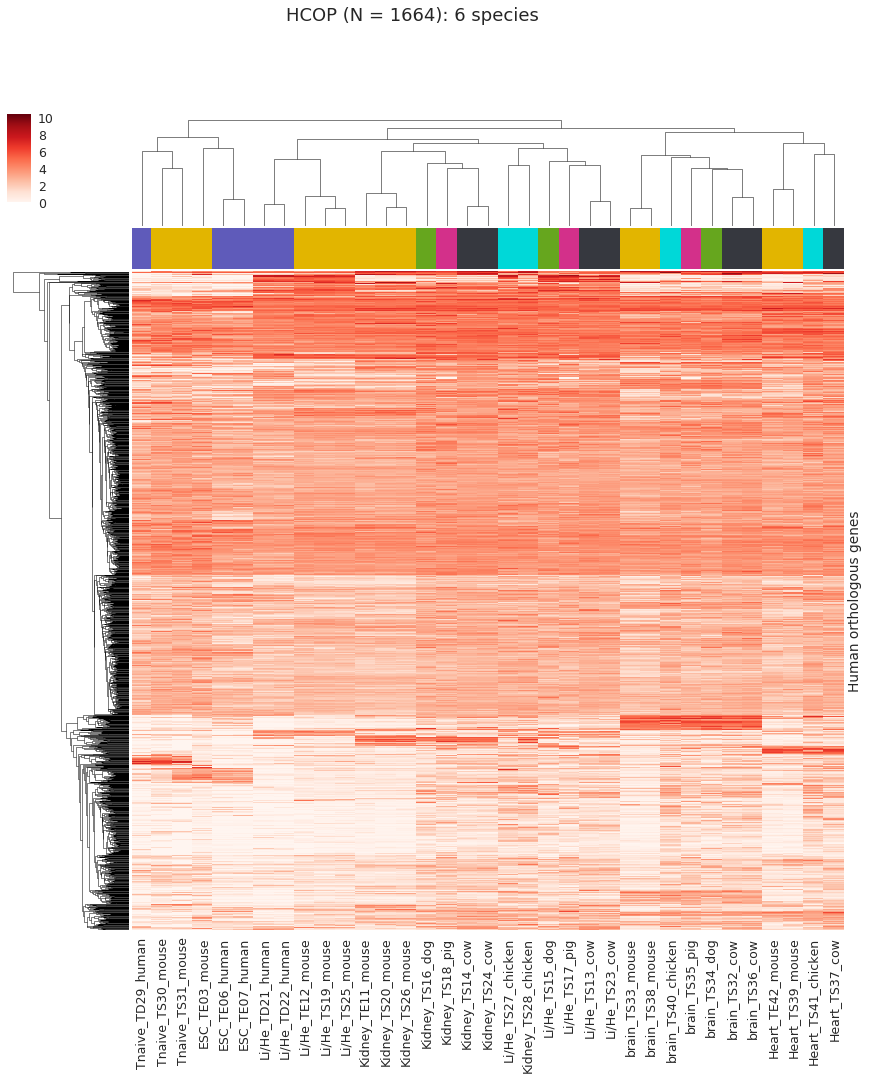

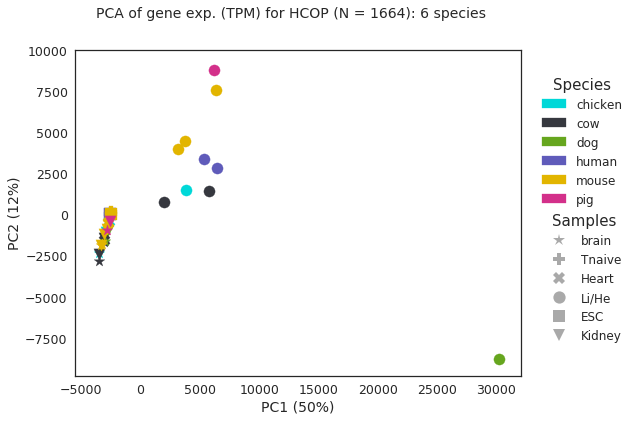

run_hcop executed


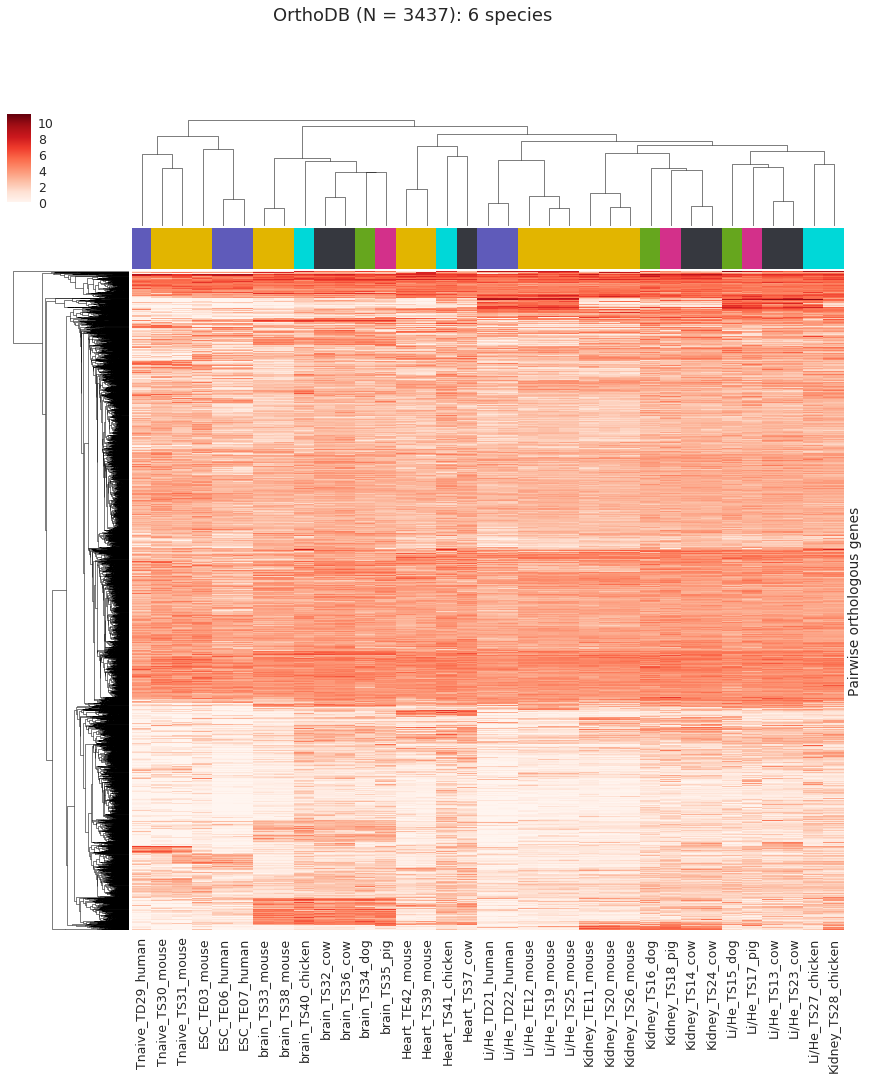

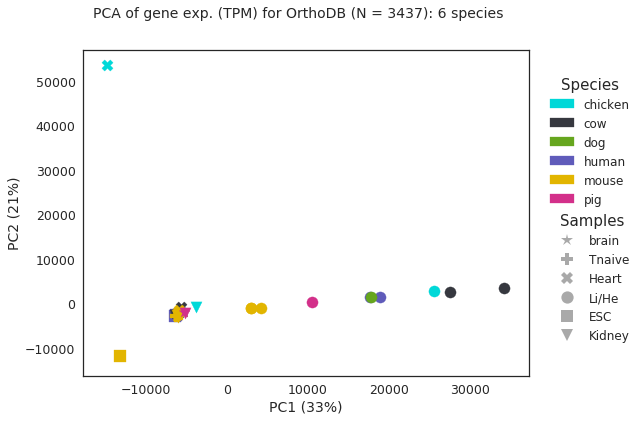

run_orthodb executed


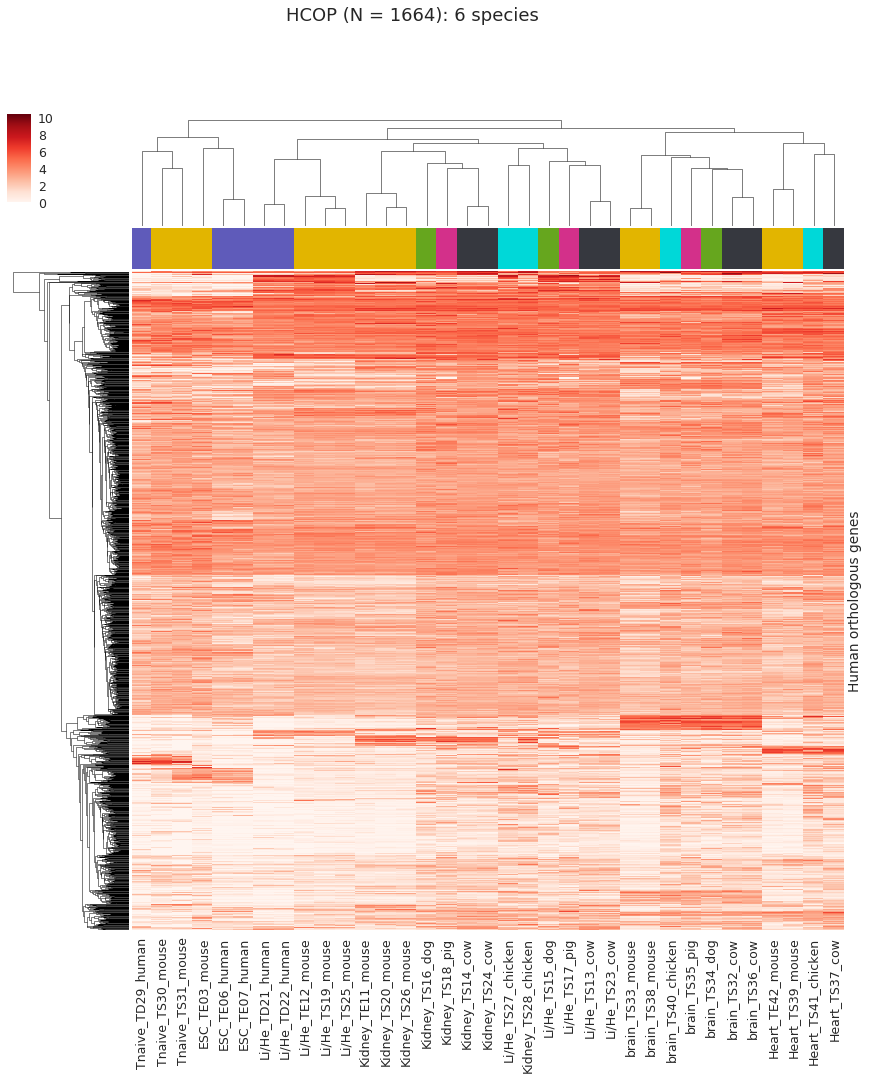

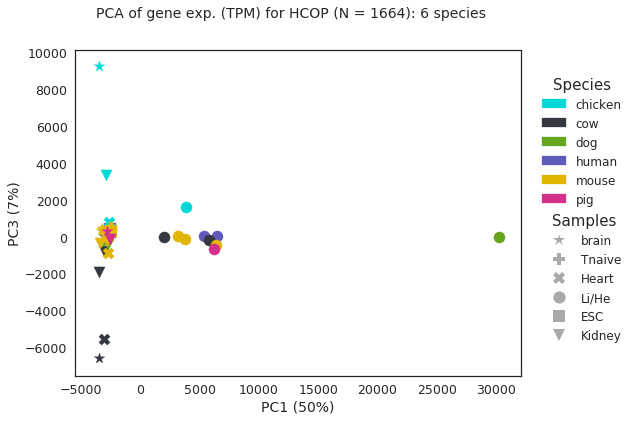

run_hcop executed


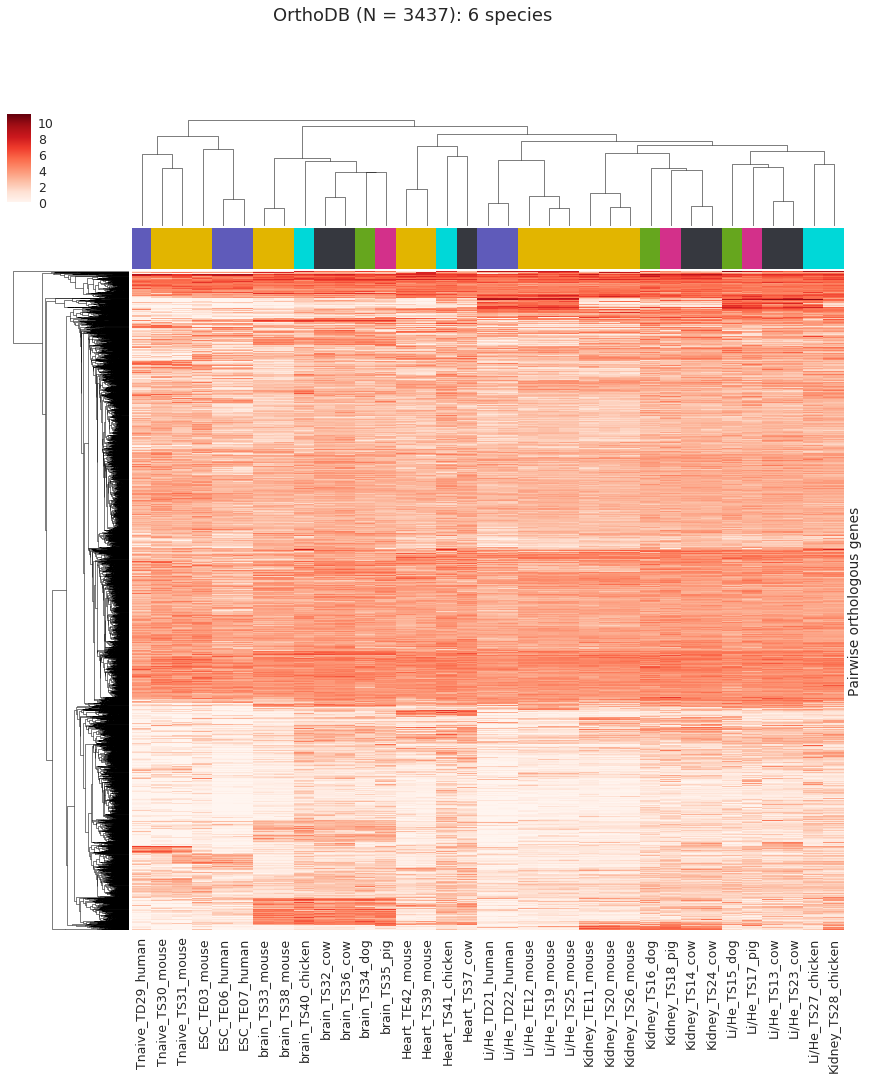

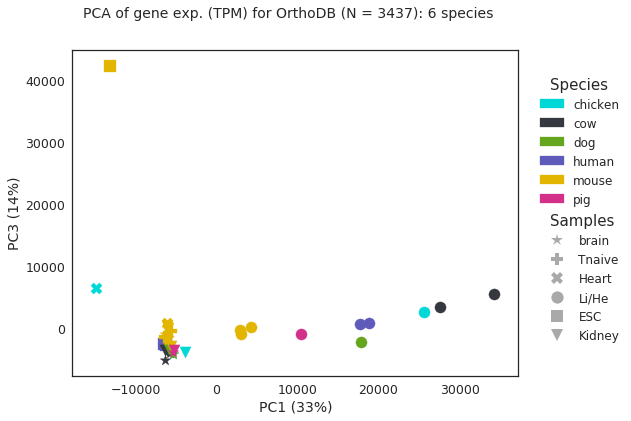

run_orthodb executed


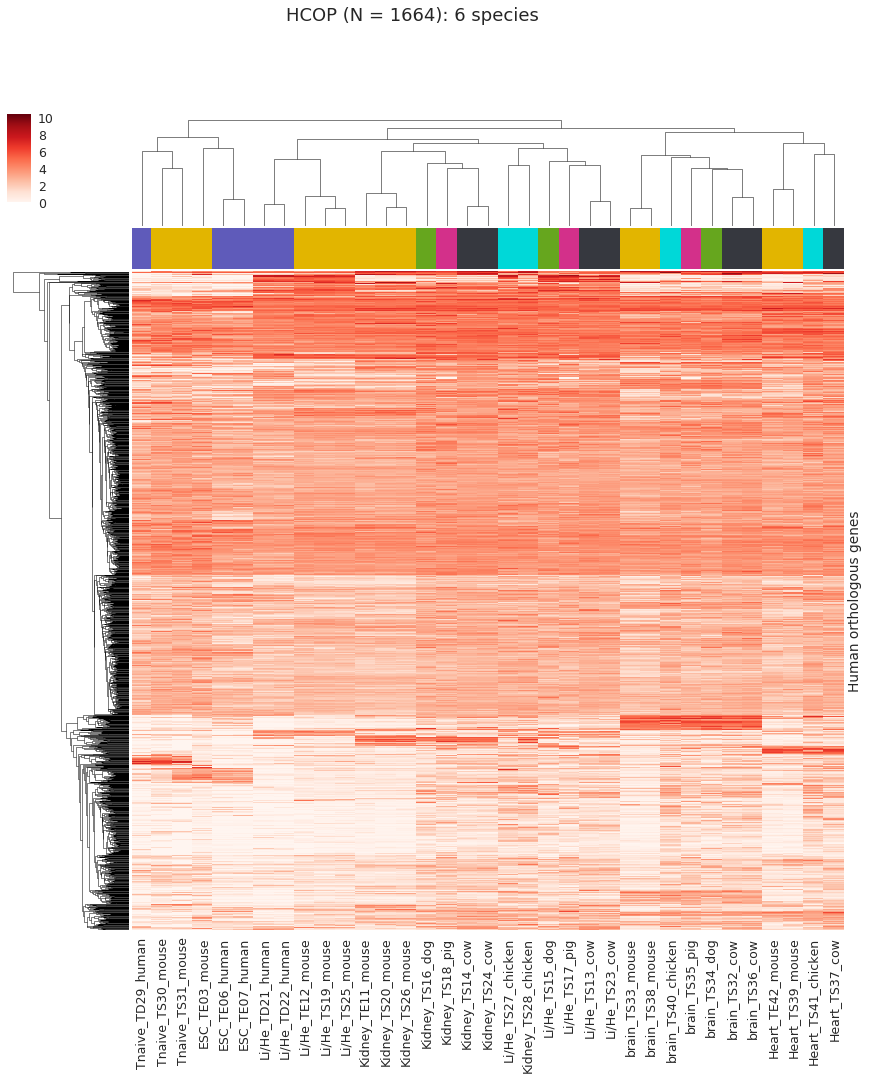

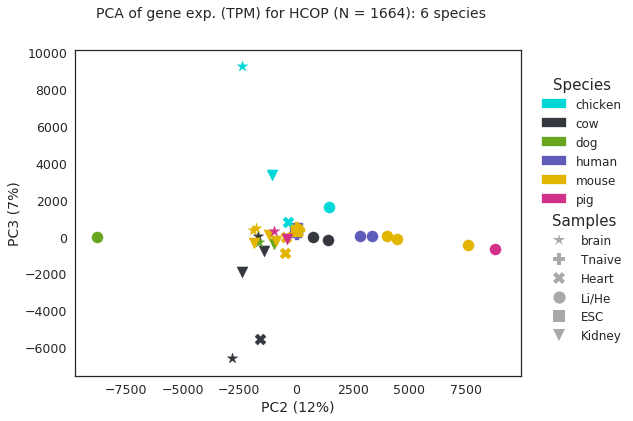

run_hcop executed


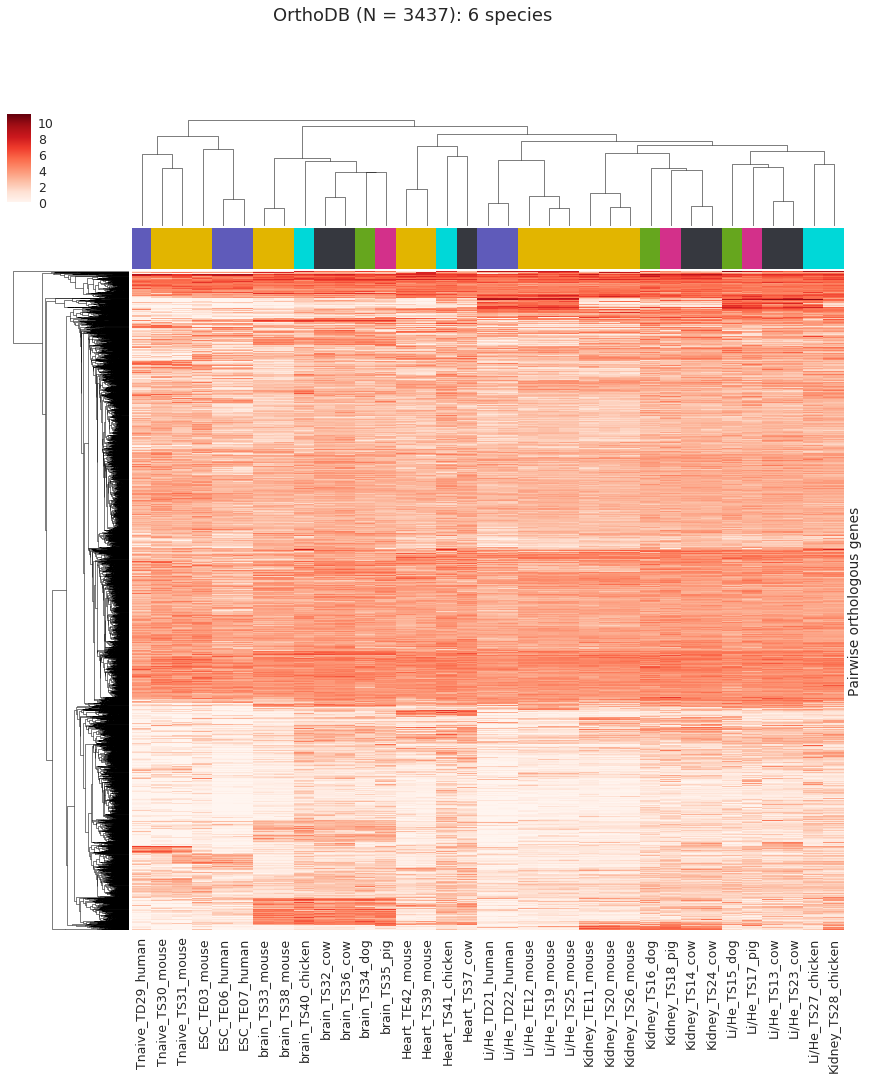

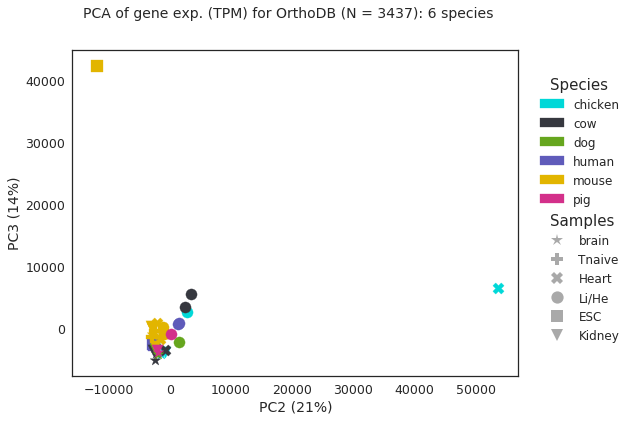

run_orthodb executed


In [3]:
%matplotlib inline

import os as os
import numpy as np
import json as js
import pandas as pd
import sklearn.decomposition as decomp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
data_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))

pca_comp_x = None
pca_comp_y = None

exec_hcop = True
exec_orthodb = True
exec_expest_cluster = False
exec_expest_corr = False

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def run_hcop(pc1, pc2):
    if not exec_hcop:
        return False
    hcop_data = os.path.join(data_folder, 'orthopred_hcop_6species.h5')
    with pd.HDFStore(hcop_data, 'r') as hdf:
        expdata = hdf['/matrix/auto/data']
        num_species = len([c for c in expdata.columns if c.endswith('_name')])
        drop_cols = [c for c in expdata.columns if c.endswith('_name') or c.endswith('_symbol')]
        drop_cols.extend([c for c in expdata.columns if any([x in c for x in ['MEL', 'K562', 'GM12878', 'CH12']])])
        expdata.drop(drop_cols, axis=1, inplace=True)
    expdata.index.name = 'Human orthologous genes'
    smp_ann = annotate_samples(expdata.columns)
    plt_title = 'HCOP (N = {}): {} species'.format(expdata.shape[0], num_species)
    heatm = plot_heatmap(expdata.copy(), plt_title, smp_ann)
    if save_figures:
        outpath = os.path.join(out_folder, 'supp', 'fig_X_supp_hcop-cluster_{}spec.svg'.format(num_species))
        heatm.savefig(outpath)
        outpath = outpath.replace('.svg', '.png')
        heatm.savefig(outpath, dpi=300)
    scat, exart = plot_pca_scatter(expdata.copy(), plt_title, smp_ann, pc1, pc2)
    if save_figures:
        outpath = os.path.join(out_folder, 'main',
                               'fig_X_main_hcop-pca_{}spec_{}vs{}.svg'.format(num_species, pc1 + 1, pc2 + 1))
        scat.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        outpath = outpath.replace('.svg', '.png')
        scat.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
    return True


def run_orthodb(pc1, pc2):
    if not exec_orthodb:
        return False
    odb_data = os.path.join(data_folder, 'orthopred_odb_6species.h5')
    with pd.HDFStore(odb_data, 'r') as hdf:
        expdata = hdf['/matrix/auto/data']
        num_species = len([c for c in expdata.columns if c.endswith('_name')])
        drop_cols = [c for c in expdata.columns if c.endswith('_name') or c.endswith('_symbol')]
        drop_cols.extend([c for c in expdata.columns if any([x in c for x in ['MEL', 'K562', 'GM12878', 'CH12']])])
        expdata.drop(drop_cols, axis=1, inplace=True)
    expdata.index.name = 'Pairwise orthologous genes'
    smp_ann = annotate_samples(expdata.columns)
    plt_title = 'OrthoDB (N = {}): {} species'.format(expdata.shape[0], num_species)
    heatm = plot_heatmap(expdata.copy(), plt_title, smp_ann)
    if save_figures:
        outpath = os.path.join(out_folder, 'supp', 'fig_X_supp_orthodb-cluster_{}spec.svg'.format(num_species))
        heatm.savefig(outpath)
        outpath = outpath.replace('.svg', '.png')
        heatm.savefig(outpath, dpi=300)
    scat, exart = plot_pca_scatter(expdata.copy(), plt_title, smp_ann, pc1, pc2)
    if save_figures:
        outpath = os.path.join(out_folder, 'main',
                               'fig_X_main_orthodb-pca_{}spec_{}vs{}.svg'.format(num_species, pc1 + 1, pc2 + 1))
        scat.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        outpath = outpath.replace('.svg', '.png')
        scat.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
    return True


def run_expest():
    """
    """
    if not (exec_expest_cluster or exec_expest_corr):
        return False
    estdata = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize/exp_est_agg.h5')
    with pd.HDFStore(estdata, 'r') as hdf:
        #load_keys = [k for k in hdf.keys() if 'human/mouse' in k or 'mouse/human' in k or 'mouse/cow' in k]
        load_keys = [k for k in hdf.keys() if 'mouse/human' in k]
        for k in load_keys:
            datmat = hdf[k]
            # binarize
            off_idx = datmat < 1
            on_idx = ~off_idx
            datmat[on_idx] = 1
            datmat[off_idx] = 0
            num_genes = datmat.shape[0]
            _, subset, trg, qry = k.split('/')
            spec_color = plot_colors['species'][qry]['rgb']
            new_cols, col_colors = annotate_data_model(datmat.columns, spec_color)
            datmat.columns = new_cols
            if exec_expest_cluster:
                datmat.index.name = '{} genes'.format(qry)
                plt_title = 'Estimated expression level: {} model on {} (N = {} {} genes)'.format(trg, qry, num_genes, subset)
                heatm = plot_raw_heatmap(datmat, plt_title, col_colors)
                if save_figures:
                    outpath = os.path.join(out_folder, 'supp',
                                          'fig_X_supp_expest-cluster_{}_{}-to-{}.svg'.format(subset, trg, qry))
                    print('Saving {}...'.format(os.path.basename(outpath)))
                    heatm.savefig(outpath)
                    print('Saved: {}'.format(os.path.basename(outpath)))
            elif exec_expest_corr:
                log_data = np.log10(datmat + 1)
                corr_data = reduce_plot_data(log_data.copy())
                plt_title = 'Correlation of true/est. expression level: {} model on {} (N = {} {} genes)'.format(trg, qry, num_genes, subset)
                #heatm = plot_corr_heatmap(corr_data, plt_title, None)
            else:
                return False
    return True
            

def make_rgb_tint(color):
    """
    """
    r, g, b = color
    new_r = r + (1 - r) * 0.5
    new_g = g + (1 - g) * 0.5
    new_b = b + (1 - b) * 0.5
    return (new_r, new_g, new_b)
    
    
def annotate_data_model(columns, base_color):
    """
    """
    new_cols = []
    col_colors = []
    for c in columns:
        parts = c.split('_')
        parts[1] = plot_labels[parts[1]]
        if 'G0' in c:
            # model column
            col_colors.append(make_rgb_tint(base_color))
            new_cols.append('_'.join(parts))
        else:
            col_colors.append(base_color)
            new_cols.append('_'.join(parts))
    
    return new_cols, col_colors
    

def reduce_plot_data(dataset):
    keep_columns = []
    samples = dataset.columns.tolist()
    samples = ['Index'] + samples
    corr = dataset.corr(method='spearman')
    best_models = []
    for row in corr.itertuples():
        my_max = 0.
        my_partner = ''
        sample = row.Index
        if 'G0' in sample:
            continue
        for idx, item in enumerate(row):
            if isinstance(item, str):
                continue
            if item == 1.:
                continue
            if 'G0' not in samples[idx]:
                continue
            if item > my_max:
                my_max = item
                my_partner = samples[idx]
        keep_columns.append(sample)
        keep_columns.append(my_partner)
        best_models.append((sample, my_partner, my_max))
    best_models = sorted(best_models)
    for bm in best_models:
        print(bm)
    print('========')
    dataset = dataset.loc[:, keep_columns]
    corr_data = dataset.corr(method='spearman')
    return corr_data
       
def annotate_samples(samples):
    """
    """
    annotation = dict()
    for s in samples:
        sid, assm, bio = s.split('_')
        color = plot_colors['assembly'][assm]['rgb']
        spec = plot_colors['mapping'][assm]['species']
        biolabel = plot_labels[bio]
        shape = plot_shapes[bio]
        annotation[s] = {'color': color, 'shape': shape, 'sample': sid,
                         'label': biolabel, 'species': spec}
    return annotation


def plot_raw_heatmap(df, title, col_colors):
    """
    """
    df = np.log1p(df)
    cm = sns.clustermap(df, method='average', metric='euclidean',
                        row_cluster=True, col_cluster=True, figsize=(15, 15),
                        cmap="Reds", yticklabels=False, col_colors=col_colors)
    plt.suptitle(title)
    if show_figures:
        sns.plt.show()
    return cm


def plot_corr_heatmap(df, title, col_colors):
    """
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    hm = sns.heatmap(df, cmap='Blues', vmin=0, vmax=1, annot=False,
                     cbar=True, square=True, xticklabels=True, yticklabels=True,
                     cbar_kws=dict(label='Spearman'), ax=ax)
    plt.suptitle(title)
    if show_figures:
        sns.plt.show()
    return hm


def plot_heatmap(df, title, col_ann):
    """
    """
    col_labels = []
    col_colors = []
    for c in df.columns:
        ann = col_ann[c]
        new_label = '{}_{}_{}'.format(ann['label'], ann['sample'], ann['species'])
        col_labels.append(new_label)
        col_colors.append(ann['color'])
    df.columns = col_labels
    df = np.log1p(df)
    if df.shape[1] > 2:
        cm = sns.clustermap(df, method='average', metric='euclidean',
                            row_cluster=True, col_cluster=True, figsize=(15, 15),
                            cmap="Reds", yticklabels=False, col_colors=col_colors)
    else:
        cm = sns.clustermap(df, method='average', metric='euclidean',
                            row_cluster=True, col_cluster=False, figsize=(15, 15),
                            cmap="Reds", yticklabels=False, col_colors=col_colors)
    plt.suptitle(title)
    if show_figures:
        sns.plt.show()
    return cm


def plot_pca_scatter(df, title, sample_ann, pc1, pc2):
    """
    """
    df = df.transpose()
    labels, colors, shapes = [], [], []
    leg_spec = set()
    leg_shape = set()
    for sample in df.index:
        ann = sample_ann[sample]
        labels.append(ann['label'])
        colors.append(ann['color'])
        shapes.append(ann['shape'])
        leg_spec.add((ann['species'], tuple(ann['color'])))
        leg_shape.add((ann['shape'], ann['label']))
    leg_spec = sorted(leg_spec)
    leg_shape = sorted(leg_shape)
    pca_red = decomp.PCA(n_components=0.95)
    red_data = pca_red.fit_transform(df)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    for x, y, c, l, m in zip(red_data[:, pc1], red_data[:, pc2], colors, labels, shapes):
        plt.scatter(x, y, color=c, label=l, marker=m, s=125)
    
    # legend for bio sample
    shape_handles = []
    for s, l in leg_shape:
        shape_handles.append(plt.Line2D([], [], marker=s, linestyle='',
                                        label=l, c='darkgray'))
    leg_sample = plt.legend(handles=shape_handles, loc=7, title='Samples', markerscale=1.75,
                            fontsize=12, bbox_to_anchor=(1.25, 0.3))
    ax = plt.gca().add_artist(leg_sample)
    # legend for species
    species_handles = []
    for entry in leg_spec:
        species_handles.append(mpatches.Patch(color=entry[1], label=entry[0]))

    leg_spec = plt.legend(handles=species_handles, loc=1, title='Species',
                          markerscale=1.5, fontsize=12, bbox_to_anchor=(1.25, 0.95))
    
    
    title_art = plt.suptitle('PCA of gene exp. (TPM) for ' + title, fontsize=14)
    expvar = pca_red.explained_variance_ratio_
    plt.xlabel('PC{} ({}%)'.format(pc1 + 1, int(np.round(expvar[pc1] * 100, 0))), fontsize=14)
    plt.ylabel('PC{} ({}%)'.format(pc2 + 1, int(np.round(expvar[pc2] * 100, 0))), fontsize=14)
    if show_figures:
        plt.show()
    return fig, (leg_spec, leg_sample, title_art)

for pc1, pc2 in [(0,1), (0,2), (1,2)]:
    # meeh, when bored, rewrite to avoid redoing PCA for each iter...
    execd = run_hcop(pc1, pc2)
    if execd:
        print('run_hcop executed')
    execd = run_orthodb(pc1, pc2)
    if execd:
        print('run_orthodb executed')
        
execd = run_expest()
if execd:
    print('run_expest executed')